In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filename = 'data/sfpd_clean.csv'
sfdata = pd.read_csv(filename)

In [3]:
sfdata.head()

,Unnamed: 0,Unnamed: 0.1,Category,Descript,DayOfWeek,PdDistrict,Address,X,Y,Location,CrimeCat,Hour,Month,Day,Year,zipcode
0,0,3,ROBBERY,"ROBBERY, BODILY FORCE",4,SOUTHERN,0 Block of UNITEDNATIONS PZ,-122.414318,37.779944,"(37.7799444052046, -122.414317857881)",2,21,6,16,2016,94102
1,1,6,ASSAULT,ELDER ADULT OR DEPENDENT ABUSE (NOT EMBEZZLEME...,5,NORTHERN,300 Block of FULTON ST,-122.422536,37.778796,"(37.7787958771466, -122.422536478306)",4,12,1,2,2015,94102
2,2,9,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,5,INGLESIDE,600 Block of LONDON ST,-122.437928,37.719328,"(37.7193276406568, -122.43792838007)",1,0,1,16,2015,94112
3,3,12,VEHICLE THEFT,STOLEN MOTORCYCLE,5,BAYVIEW,700 Block of SILLIMAN ST,-122.412481,37.729247,"(37.729246748441, -122.412480611343)",5,0,1,16,2015,94134
4,4,17,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,3,SOUTHERN,0 Block of FOLSOM ST,-122.390556,37.790475,"(37.7904750361645, -122.39055604599)",1,18,1,7,2015,94105


In [8]:
sfdf = sfdata.groupby(['Year', 'Month', 'zipcode', 'CrimeCat'])['Unnamed: 0'].count()
sfdf = sfdf.unstack().reset_index()
sfdf.fillna(0, inplace=True)

In [16]:
sfdf.head()

CrimeCat,Year,Month,zipcode,1,2,3,4,5,6,7,9,10
0,2003,1,94014,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
1,2003,1,94102,286.0,43.0,327.0,145.0,64.0,37.0,28.0,4.0,11.0
2,2003,1,94103,260.0,26.0,200.0,134.0,117.0,48.0,37.0,9.0,4.0
3,2003,1,94104,21.0,5.0,0.0,7.0,0.0,4.0,5.0,0.0,0.0
4,2003,1,94105,61.0,0.0,3.0,11.0,10.0,9.0,2.0,0.0,0.0


In [10]:
from sklearn.preprocessing import MinMaxScaler
X = sfdf.drop(['Year', 'Month', 'zipcode'], axis=1).values
scaler = MinMaxScaler()
X_sca = scaler.fit_transform(X)

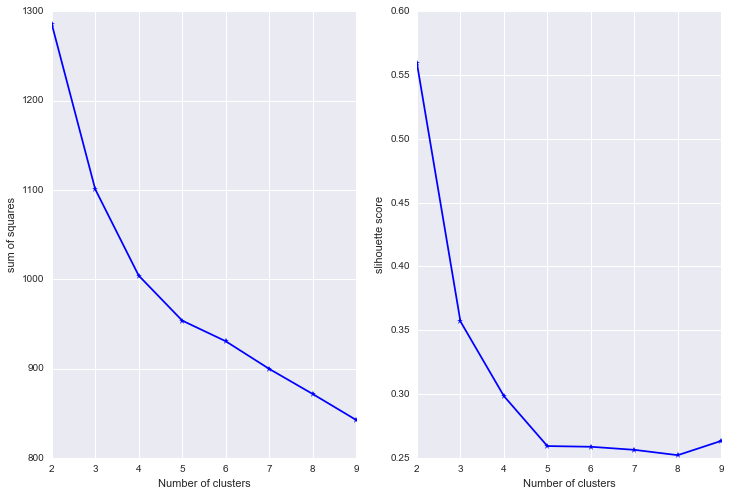

In [14]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
%matplotlib inline

scaler = StandardScaler()
X_trans = scaler.fit_transform(X)
def kmeans_all(X):
    dists = []
    scores = []
    for k in xrange(2, 10):
#         print k
        kmeanModel = KMeans(k)
        kmeanModel.fit(X)
        centroids = kmeanModel.cluster_centers_
        labels = kmeanModel.labels_
        dist = cdist(X, centroids)
        dists.append(dist.min(axis=1).sum())
        score = silhouette_score(X, labels)
        scores.append(score)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(121)
    ax1.plot(xrange(2, 10), dists, 'b*-')
    ax1.grid(True)
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('sum of squares')
    ax2 = fig.add_subplot(122)
    ax2.plot(xrange(2, 10), scores, 'b*-')
    ax2.grid(True)
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('slihouette score')
    plt.show()


def get_ref(shape, tops, bots): 
    dists = tops - bots
    ref = np.random.random(shape) * dists + bots
    return ref

def iter_kmeans(refs, k):
    vals = []
    for ref in refs:
        model = KMeans(n_clusters=k, n_init=3)
        model.fit(ref)
        vals.append(np.log(model.inertia_))
    return np.array(vals)

def gap_statistic(X, max_k=10, B=10):
    gaps = []
    gaps_minus = []
    tops = X.max(axis=0)
    bots = X.min(axis=0)
    refs = [get_ref(X.shape, tops, bots) for i in xrange(B)]
#     print refs
    for k in range(1, max_k + 1):
        km_act = KMeans(n_clusters=k, n_init=3)
        km_act.fit(X)
        ref_log_inertias = iter_kmeans(refs, k)       
        sdk = np.std(ref_log_inertias)
#         print sdk
        gap = ref_log_inertias.mean() - np.log(km_act.inertia_)
        sk = np.sqrt(1 + 1.0/B) * sdk
#         print sk
#         print "Ref: %s   Act: %s  Gap: %s" % ( ref_inertia, km_act.inertia_, gap)
        gaps.append(gap)
        gaps_minus.append(gap - sk)
    plt.figure()
    plt.plot(range(1, max_k+1), gaps, label='Gap(k)')
    plt.plot(range(max_k), gaps_minus, label='Gap(k+1) - s(k+1)')
    plt.legend(loc='best')
    plt.show()
    return gaps

kmeans_all(X_sca)

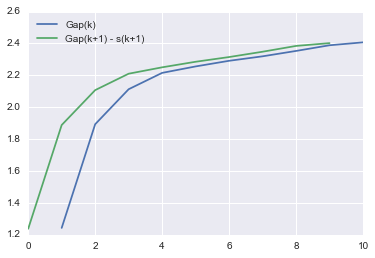

In [15]:
gaps = gap_statistic(X_sca)